In [2]:
import tensorflow as tf
import tensorflow.contrib.slim as slim
from tensorflow.python.client import timeline
from datetime import datetime
import network as vgg

def get_init_restorer():
    variables_to_restore = []
    # for var in slim.get_model_variables():
    for var in tf.global_variables():
        variables_to_restore.append(var)
    
    return tf.train.Saver(variables_to_restore)

scale_size = vgg.vgg_16.default_image_size
cache_folder = '/export/home/qliu24/qing_voting_139/qing_voting_py/cache/'
checkpoints_dir = os.path.join(cache_folder, 'checkpoints_vgg')
tf.logging.set_verbosity(tf.logging.INFO)
with tf.device('/cpu:0'):
    input_images = tf.placeholder(tf.float32, [1, None, None, 3])

vgg_var_scope = 'vgg_16'
with tf.variable_scope(vgg_var_scope, reuse=False):
    with slim.arg_scope(vgg.vgg_arg_scope()):
        _, end_points = vgg.vgg_16(input_images)
        
restorer = get_init_restorer()
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
init_op = tf.global_variables_initializer()
# Run the session:
sess = tf.Session(config=config)
# init
print(str(datetime.now()) + ': Start Init')

restorer.restore(sess, os.path.join(checkpoints_dir, 'vgg_16.ckpt'))

print(str(datetime.now()) + ': Finish Init')

2017-07-29 23:22:16.186356: Start Init
INFO:tensorflow:Restoring parameters from /export/home/qliu24/qing_voting_139/qing_voting_py/cache/checkpoints_vgg/vgg_16.ckpt
2017-07-29 23:22:17.446035: Finish Init


In [32]:
import math
import pickle
from scipy.spatial.distance import cdist
import scipy.io as sio
from myresize import myresize
import numpy as np
import sys
import os
import cv2

scale_size = 224
featDim = 512
img_mean = np.array([104., 117., 124.]).reshape(1,1,3)
'''
dir_mat = '/export/home/qliu24/VC_adv_data/cihang/adv_cls_patches/adv_mat_file/'
file_list = '/export/home/qliu24/VC_adv_data/cihang/adv_cls_patches/car_test.txt'

'''
category = 'car'
target = 'bus'

dataset_suffix = 'mergelist_rand'
Dataset = dict()
Dataset['img_dir'] = '/export/home/qliu24/dataset/PASCAL3D+_release1.1/Images/{0}_imagenet/'
Dataset['anno_dir'] = '/export/home/qliu24/dataset/PASCAL3D+_release1.1/Annotations/{0}_imagenet/'
Dataset['gt_dir'] = '/export/home/qliu24/qing_voting_139/qing_voting_py/intermediate/ground_truth_data/'
Dataset['train_list'] = os.path.join(Dataset['gt_dir'], '{0}_'+ '{0}_train.txt'.format(dataset_suffix))
Dataset['test_list'] = os.path.join(Dataset['gt_dir'], '{0}_'+ '{0}_test.txt'.format(dataset_suffix))
Dataset['adv_dir'] = '/export/home/qliu24/VC_adv_data/qing/VGG_adv/{}_{}'

dir_adv = Dataset['adv_dir'].format(category, target)
# dir_img = Dataset['img_dir'].format(category)
file_list = Dataset['test_list'].format(category)

with open(file_list, 'r') as fh:
    content = fh.readlines()
    
img_list = [x.strip().split() for x in content]
img_num = len(img_list)
print('total number of images: {0}'.format(img_num))

# r_ls1=[]
# r_ls2=[]
img_ori=[]
img_fool=[]
for nn in range(img_num):
    file_adv = os.path.join(dir_adv, '{0}.pickle'.format(img_list[nn][0]))
    assert(os.path.isfile(file_adv))
    with open(file_adv, 'rb') as fh:
        im_ori, _, im_fool = pickle.load(fh)
    
    # file_img = os.path.join(dir_img, '{0}.JPEG'.format(img_list[nn][0]))
    # assert(os.path.isfile(file_img))
    # im_ori = cv2.imread(file_img)
    # im_ori = myresize(im_ori, scale_size, 'short')
    
    img_ori.append(im_ori)
    img_fool.append(im_fool)
    # r_ls1.append(np.max(r))
    # r_ls2.append(np.min(r))
    
# print(np.mean(r_ls1), np.min(r_ls1), np.max(r_ls1))
# print(np.mean(r_ls2), np.min(r_ls2), np.max(r_ls2))
print(len(img_ori))

total number of images: 1000
1000


In [33]:
label_ls = []
prob_ls = []
for nn in range(img_num):
    img = np.copy(img_ori[nn]).astype('float64')
    img -= img_mean
    img = img.reshape(np.concatenate([[1],img.shape]))
    scores = sess.run(end_points['vgg_16/fc8/reduced'], feed_dict={input_images: img})[0]
    probs_ori = np.exp(scores)/np.sum(np.exp(scores))
    # label_ls.append(np.argmax(scores))
    
    if nn%50==0:
        print(nn, end=' ', flush=True)
    
    img = np.copy(img_fool[nn]).astype('float64')
    img -= img_mean
    img = img.reshape(np.concatenate([[1],img.shape]))
    scores = sess.run(end_points['vgg_16/fc8/reduced'], feed_dict={input_images: img})[0]
    probs_fool = np.exp(scores)/np.sum(np.exp(scores))
    
    img = np.copy(img_fool[nn]).astype('uint8')
    img = cv2.medianBlur(img,5)
    img = img.astype('float64')
    img -= img_mean
    img = img.reshape(np.concatenate([[1],img.shape]))
    scores = sess.run(end_points['vgg_16/fc8/reduced'], feed_dict={input_images: img})[0]
    probs_res = np.exp(scores)/np.sum(np.exp(scores))
    
    img = np.copy(img_fool[nn]).astype('float64')
    noise = np.zeros_like(img)
    noise = cv2.randn(noise,(0),(15))
    img += noise
    img -= img_mean
    img = img.reshape(np.concatenate([[1],img.shape]))
    scores = sess.run(end_points['vgg_16/fc8/reduced'], feed_dict={input_images: img})[0]
    probs_randn = np.exp(scores)/np.sum(np.exp(scores))
    
    label_ls.append((np.argmax(probs_ori), np.argmax(probs_fool), np.argmax(probs_res), np.argmax(probs_randn)))
    prob_ls.append((np.max(probs_ori), np.max(probs_fool), np.max(probs_res), np.max(probs_randn)))
    
print(len(label_ls))

0 50 100 150 200 250 300 350 400 450 500 550 600 650 700 750 800 850 900 950 1000


In [36]:
car_labels = [436, 468, 511, 609, 627, 656, 717, 734, 751, 817]
bus_labels = [654, 705, 779, 874]
aeroplane_labels = [404, 895]


prob_ls = np.array(prob_ls)
label_ls = np.array(label_ls, dtype='int')
N = label_ls.shape[0]

obj_labels = bus_labels
accu_1 = np.sum([ll in obj_labels for ll in label_ls[:,0]])/label_ls.shape[0]
print('original accuracy: {}'.format(accu_1))
accu_2 = np.sum([ll in obj_labels for ll in label_ls[:,1]])/label_ls.shape[0]
print('fool accuracy: {}'.format(accu_2))
accu_3 = np.sum([ll in obj_labels for ll in label_ls[:,2]])/label_ls.shape[0]
print('rescued accuracy: {}'.format(accu_3))
accu_4 = np.sum([ll[0] in obj_labels and ll[0]==ll[2] for ll in label_ls])/label_ls.shape[0]
print('same category accuracy: {}'.format(accu_4))
accu_5 = np.sum([ll in obj_labels for ll in label_ls[:,3]])/label_ls.shape[0]
print('randn accuracy: {}'.format(accu_5))
accu_6 = np.sum([ll[0] in obj_labels and ll[0]==ll[3] for ll in label_ls])/label_ls.shape[0]
print('same category accuracy: {}'.format(accu_6))

print('prob thresholds')
accu_1 = np.sum([label_ls[nn,0] in obj_labels and prob_ls[nn,0]>0.5 for nn in range(N)])/N
print('original accuracy: {}'.format(accu_1))
accu_2 = np.sum([label_ls[nn,1] in obj_labels and prob_ls[nn,1]>0.5 for nn in range(N)])/N
print('fool accuracy: {}'.format(accu_2))
accu_3 = np.sum([label_ls[nn,2] in obj_labels and prob_ls[nn,2]>0.5 for nn in range(N)])/N
print('rescued accuracy: {}'.format(accu_3))

accu_4 = np.sum([label_ls[nn,0] in obj_labels and label_ls[nn,0] == label_ls[nn,2] and prob_ls[nn,0]>0.5 and prob_ls[nn,2]>0.5 for nn in range(N)])/N
print('same category accuracy: {}'.format(accu_4))

accu_5 = np.sum([label_ls[nn,3] in obj_labels and prob_ls[nn,3]>0.5 for nn in range(N)])/N
print('randn accuracy: {}'.format(accu_5))

accu_6 = np.sum([label_ls[nn,0] in obj_labels and label_ls[nn,0] == label_ls[nn,3] and prob_ls[nn,0]>0.5 and prob_ls[nn,3]>0.5 for nn in range(N)])/N
print('same category accuracy: {}'.format(accu_6))

original accuracy: 0.014
fool accuracy: 0.999
rescued accuracy: 0.03
same category accuracy: 0.005
randn accuracy: 0.557
same category accuracy: 0.005
prob thresholds
original accuracy: 0.006
fool accuracy: 0.997
rescued accuracy: 0.004
same category accuracy: 0.001
randn accuracy: 0.237
same category accuracy: 0.001


original accuracy: 0.632
fool accuracy: 0.0
rescued accuracy: 0.082
same category accuracy: 0.056


In [28]:
idx_to_lb_file = '/export/home/qliu24/VC_adv_data/qing/VGG_adv/vgg_idx_to_label.pickle'
with open(idx_to_lb_file,'rb') as fh:
    idx_to_lb = pickle.load(fh)

for ii in np.unique(label_ls):
    print('{};{};{}'.format(np.sum(np.array(label_ls)==ii), ii, idx_to_lb[ii]))

1;406;altar
1;412;ashcan, trash can, garbage can, wastebin, ash bin, ash-bin, ashbin, dustbin, trash barrel, trash bin
1;421;bannister, banister, balustrade, balusters, handrail
2;428;barrow, garden cart, lawn cart, wheelbarrow
186;444;bicycle-built-for-two, tandem bicycle, tandem
1;513;cornet, horn, trumpet, trump
1;518;crash helmet
1;545;electric fan, blower
1;611;jigsaw puzzle
4;612;jinrikisha, ricksha, rickshaw
1;664;monitor
3;665;moped
122;671;mountain bike, all-terrain bike, off-roader
1;682;obelisk
2;703;park bench
1;704;parking meter
1;718;pier
4;730;plow, plough
1;738;pot, flowerpot
1;762;restaurant, eating house, eating place, eatery
1;776;sax, saxophone
1;790;shopping basket
1;821;steel arch bridge
1;865;toyshop
53;870;tricycle, trike, velocipede
8;880;unicycle, monocycle
2;970;alp
2;975;lakeside, lakeshore
1;977;sandbar, sand bar
1;978;seashore, coast, seacoast, sea-coast


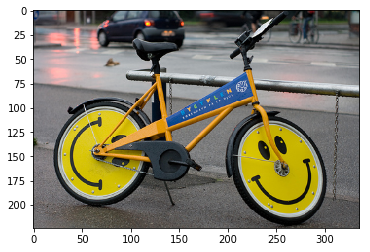

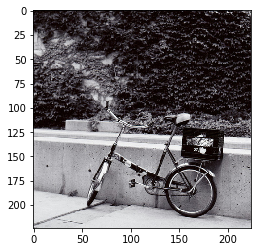

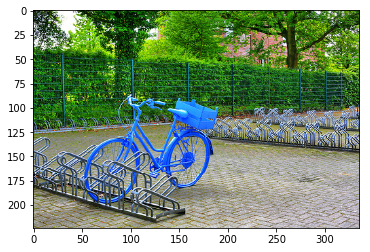

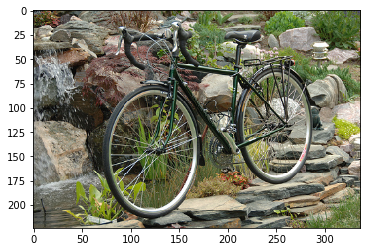

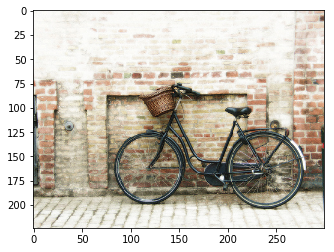

In [29]:
import matplotlib.pyplot as plt

to_disp = np.where(np.array(label_ls)==870)[0]
for nn in to_disp[0:5]:
    plt.imshow(img_ori[nn][:,:,[2,1,0]].astype('uint8'))
    plt.show()
    # plt.imshow(img_fool[nn][:,:,[2,1,0]].astype('uint8'))
    # plt.show()

In [13]:
import math
import pickle
from scipy.spatial.distance import cdist
import scipy.io as sio
from myresize import myresize
import numpy as np
import sys
import os
import cv2

scale_size = 224
featDim = 512
img_mean = np.array([104., 117., 124.]).reshape(1,1,3)
'''
dir_mat = '/export/home/qliu24/VC_adv_data/cihang/adv_cls_patches/adv_mat_file/'
file_list = '/export/home/qliu24/VC_adv_data/cihang/adv_cls_patches/car_test.txt'

'''
category = 'car'
target = 'bus'

dataset_suffix = 'mergelist_rand'
Dataset = dict()
Dataset['img_dir'] = '/export/home/qliu24/dataset/PASCAL3D+_release1.1/Images/{0}_imagenet/'
Dataset['anno_dir'] = '/export/home/qliu24/dataset/PASCAL3D+_release1.1/Annotations/{0}_imagenet/'
Dataset['gt_dir'] = '/export/home/qliu24/qing_voting_139/qing_voting_py/intermediate/ground_truth_data/'
Dataset['train_list'] = os.path.join(Dataset['gt_dir'], '{0}_'+ '{0}_train.txt'.format(dataset_suffix))
Dataset['test_list'] = os.path.join(Dataset['gt_dir'], '{0}_'+ '{0}_test.txt'.format(dataset_suffix))
Dataset['adv_dir'] = '/export/home/qliu24/VC_adv_data/qing/VGG_adv/{}_{}'

dir_adv = Dataset['adv_dir'].format(category, target)
# dir_img = Dataset['img_dir'].format(category)
file_list = Dataset['test_list'].format(category)

with open(file_list, 'r') as fh:
    content = fh.readlines()
    
img_list = [x.strip().split() for x in content]
img_num = len(img_list)
print('total number of images: {0}'.format(img_num))

# r_ls1=[]
# r_ls2=[]
img_ori=[]
img_fool=[]
for nn in range(img_num):
    file_adv = os.path.join(dir_adv, '{0}.pickle'.format(img_list[nn][0]))
    assert(os.path.isfile(file_adv))
    with open(file_adv, 'rb') as fh:
        im_ori, _, im_fool = pickle.load(fh)
    
    # file_img = os.path.join(dir_img, '{0}.JPEG'.format(img_list[nn][0]))
    # assert(os.path.isfile(file_img))
    # im_ori = cv2.imread(file_img)
    # im_ori = myresize(im_ori, scale_size, 'short')
    
    img_ori.append(im_ori)
    img_fool.append(im_fool)
    # r_ls1.append(np.max(r))
    # r_ls2.append(np.min(r))
    
# print(np.mean(r_ls1), np.min(r_ls1), np.max(r_ls1))
# print(np.mean(r_ls2), np.min(r_ls2), np.max(r_ls2))
print(len(img_ori))

total number of images: 1000
1000


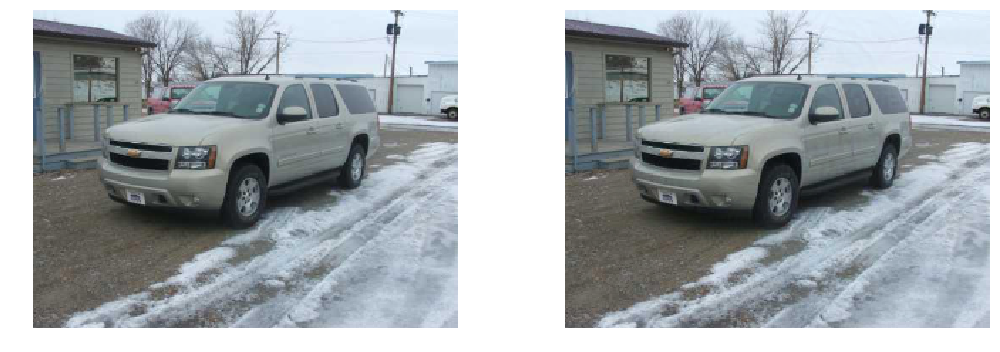

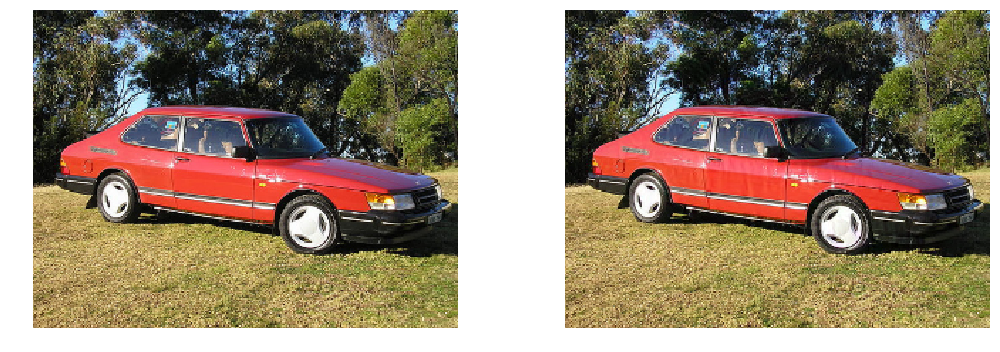

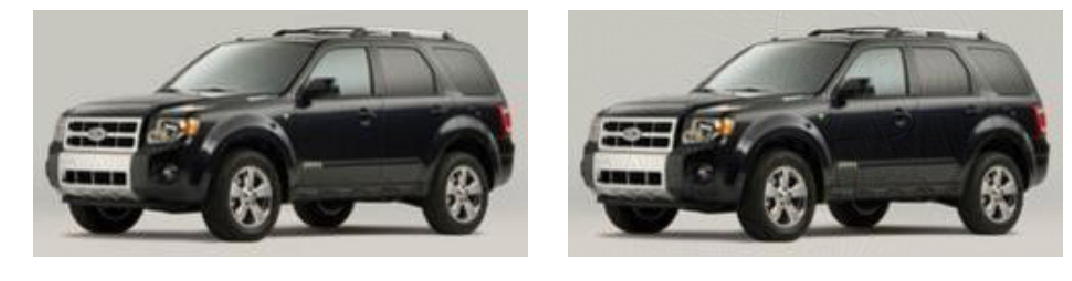

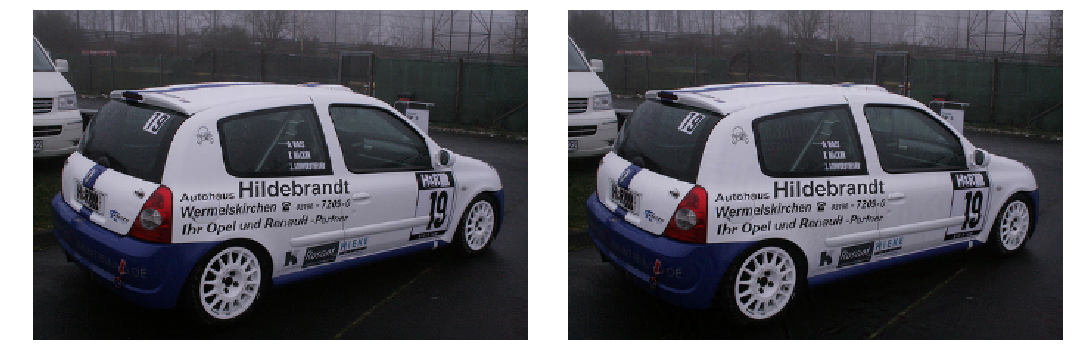

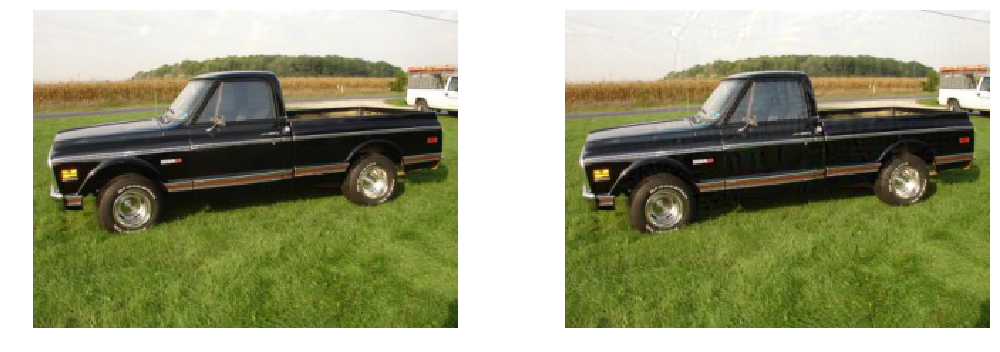

In [14]:
import matplotlib.pyplot as plt
for nn in range(5,10):
    f, ax = plt.subplots(1,2, figsize=(15,5))
    ax[0].imshow(img_ori[nn][:,:,[2,1,0]].astype('uint8'))
    ax[1].imshow(img_fool[nn][:,:,[2,1,0]].astype('uint8'))
    plt.tight_layout()
    ax[0].axis('off')
    ax[1].axis('off')
    plt.show()